In [1]:
from pathlib import Path
from brainlit.utils.Neuron_trace import NeuronTrace
from brainlit.algorithms.trace_analysis.fit_spline import GeometricGraph
from scipy.interpolate import splprep, BSpline, CubicHermiteSpline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from scipy.interpolate import splev
from brainlit.map_neurons.map_neurons import DiffeomorphismAction, transform_GeometricGraph
import pandas as pd
import numpy as np
import h5py
from brainlit.map_neurons.map_neurons import CloudReg_Transform
from scipy.spatial.distance import cosine
from tqdm import tqdm
from cloudvolume import CloudVolume
%matplotlib widget

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Toy example

In [ ]:
dict = {"x": [0, 0], "y": [-1, 1], "z": [0, 0], "sample": [1,2], "parent": [-1, 1]}
df = pd.DataFrame(data = dict)

G = GeometricGraph(df = df)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")
soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.fit_spline_tree_invariant()
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1]+0.1, 0.1)
    tck = spline[0]
    pts = splev(u, tck)

    ax.plot(pts[0], pts[1], pts[2], linestyle='-',color='midnightblue',linewidth=0.8)
#ax.scatter(soma[0],soma[1],soma[2], c='darkorange', s=5)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)

plt.title("Original curve")

plt.show()

## Custom transformation

In [ ]:
#only move points
class Triangle_0(DiffeomorphismAction):
    def __init__(self):
        pass

    def evaluate(self, position: np.array) -> np.array:
        transformed_position = position.copy()
        #if x1 between 

        tophalf = np.logical_and(position[:,1] >= 0, position[:,1] <= 1)
        bottomhalf = np.logical_and(position[:,1] < 0, position[:,1] >= -1)

        newvals = position[tophalf]
        newvals[:,0] += position[tophalf][:,1]-1
        transformed_position[tophalf] = newvals

        newvals = position[bottomhalf]
        newvals[:,0] += -1*position[bottomhalf][:,1]-1
        transformed_position[bottomhalf] = newvals
        
        return transformed_position
    
    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        return deriv

#move points and derivatives
class Triangle_1(Triangle_0):
    def __init__(self):
        pass
    
    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        transformed_deriv = deriv.copy()

        transformed_deriv[np.logical_and(position[:,1] >= 0, position[:,1] <= 1)] = np.matmul(np.array([[1,1,0],[0,1,0],[0,0,1]]), deriv[np.logical_and(position[:,1] >= 0, position[:,1] <= 1)].T).T
        transformed_deriv[np.logical_and(position[:,1] >= -1, position[:,1] < 0)] = np.matmul(np.array([[1,-1,0],[0,1,0],[0,0,1]]), deriv[np.logical_and(position[:,1] >= -1, position[:,1] < 0)].T).T
        return transformed_deriv


In [ ]:
diff = Triangle_0()

x, y, z = np.meshgrid(np.arange(-1, 1.2, 0.25),
                      np.arange(-1, 1.2, 0.25),
                      [np.arange(-0.5, 0.6, 1)])


shp = x.shape

position = np.stack((x,y,z), axis=3)
position = np.reshape(position, [-1, 3])
transformed_position = diff.evaluate(position)
displacement = transformed_position - position
u = np.reshape(displacement[:,0], shp)
v = np.reshape(displacement[:,1], shp)
w = np.reshape(displacement[:,2], shp)

fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')

ax.quiver(x, y, z, u, v, w, length=0.2)

plt.title("Displacement Field")
plt.show()

## Perform transformation

In [ ]:
diff = Triangle_1()
G_tranformed = transform_GeometricGraph(G, diff)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")

#act on dense points
soma = np.array(G_tranformed.nodes[G_tranformed.root]["loc"])
spline_tree = G.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    u = np.arange(u[0], u[-1]+0.1, u[-1]-u[0])
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, label="0th Order")

    u = np.arange(u[0], u[-1]+0.1, 0.1)
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, label="Mapping Dense Points")

#act on derivatives
soma = np.array(G_tranformed.nodes[G_tranformed.root]["loc"])
spline_tree = G_tranformed.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1]+0.1, 0.1)
    chspline = spline[0]
    pts = chspline(u)

    ax.plot(pts[:,0], pts[:,1], pts[:,2], linestyle='-',linewidth=0.8, label="1st Order")
ax.scatter(soma[0],soma[1],soma[2], c='darkorange', s=5)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
plt.title("0th order Transformation")
plt.legend()
plt.show()

## Toy Example multiple segments

In [ ]:
dict = {"x": [0, -1, -1], "y": [-1, 0, 1], "z": [0, 0, 1], "sample": [1,2, 3], "parent": [-1, 1, 2]}
df = pd.DataFrame(data = dict)

G = GeometricGraph(df = df)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(df['x'].to_numpy(), df['y'].to_numpy(), df['z'].to_numpy(), linestyle='-',linewidth=0.8, label="original points")

soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.fit_spline_tree_invariant()
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    pts = splev(u, tck)
    ax.plot(pts[0], pts[1], pts[2], linestyle='-',linewidth=0.8, label="line segment")

    u = np.arange(u[0], u[-1]+0.01, 0.01)
    pts = splev(u, tck)

    ax.plot(pts[0], pts[1], pts[2], linestyle='-',linewidth=0.8, label="spline")
#ax.scatter(soma[0],soma[1],soma[2], c='darkorange', s=5)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
ax.legend()

plt.title("Original curve")

plt.show()

## Gaussian warp

In [ ]:
from scipy.stats import norm

#only move points
class Gaussian_0(DiffeomorphismAction):
    def __init__(self):
        pass

    def evaluate(self, position: np.array) -> np.array:
        transformed_position = position.copy()
        transformed_position[:,0] += norm.pdf(transformed_position[:,1], scale = 0.5)
        
        return transformed_position
    
    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        return deriv

#move points and derivatives
class Gaussian_1(Gaussian_0):
    def __init__(self):
        pass
    
    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        transformed_deriv = deriv.copy()
        for i, (pos, d) in enumerate(zip(position, deriv)):
            J = np.eye(3)
            J[0,1] = norm.pdf(pos[1], scale = 0.5)*(-2*pos[1])
            transformed_deriv[i,:] = np.matmul(J, d).T

        return transformed_deriv


In [ ]:
diff = Gaussian_0()

x, y, z = np.meshgrid(np.arange(-1, 1.2, 0.25),
                      np.arange(-1, 1.2, 0.25),
                      [np.arange(-0.5, 0.6, 1)])


shp = x.shape

position = np.stack((x,y,z), axis=3)
position = np.reshape(position, [-1, 3])
transformed_position = diff.evaluate(position)
displacement = transformed_position - position
u = np.reshape(displacement[:,0], shp)
v = np.reshape(displacement[:,1], shp)
w = np.reshape(displacement[:,2], shp)

fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')

ax.quiver(x, y, z, u, v, w, length=0.2)

plt.title("Displacement Field")
plt.show()

In [ ]:
diff = Gaussian_1()
G_tranformed = transform_GeometricGraph(G, diff)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")

#act on dense points
soma = np.array(G_tranformed.nodes[G_tranformed.root]["loc"])
spline_tree = G.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    #trace points only
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, label="0th Order")

    #dense spline points
    u = np.arange(u[0], u[-1]+0.01, 0.01)
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, label="Mapping Dense Points")

#act on derivatives
soma = np.array(G_tranformed.nodes[G_tranformed.root]["loc"])
spline_tree = G_tranformed.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1]+0.01, 0.01)
    chspline = spline[0]
    pts = chspline(u)

    ax.plot(pts[:,0], pts[:,1], pts[:,2], linestyle='-',linewidth=0.8, label="1st Order")
ax.scatter(soma[0],soma[1],soma[2], c='darkorange', s=5)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
plt.legend()
plt.show()

## CloudReg + Toy Neuron

integrating velocity field: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]
/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_85078/1367919884.py:25: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


average squared deformation 48242.56629950956
average 1-cosine between derivatives 0.0028320670015185966


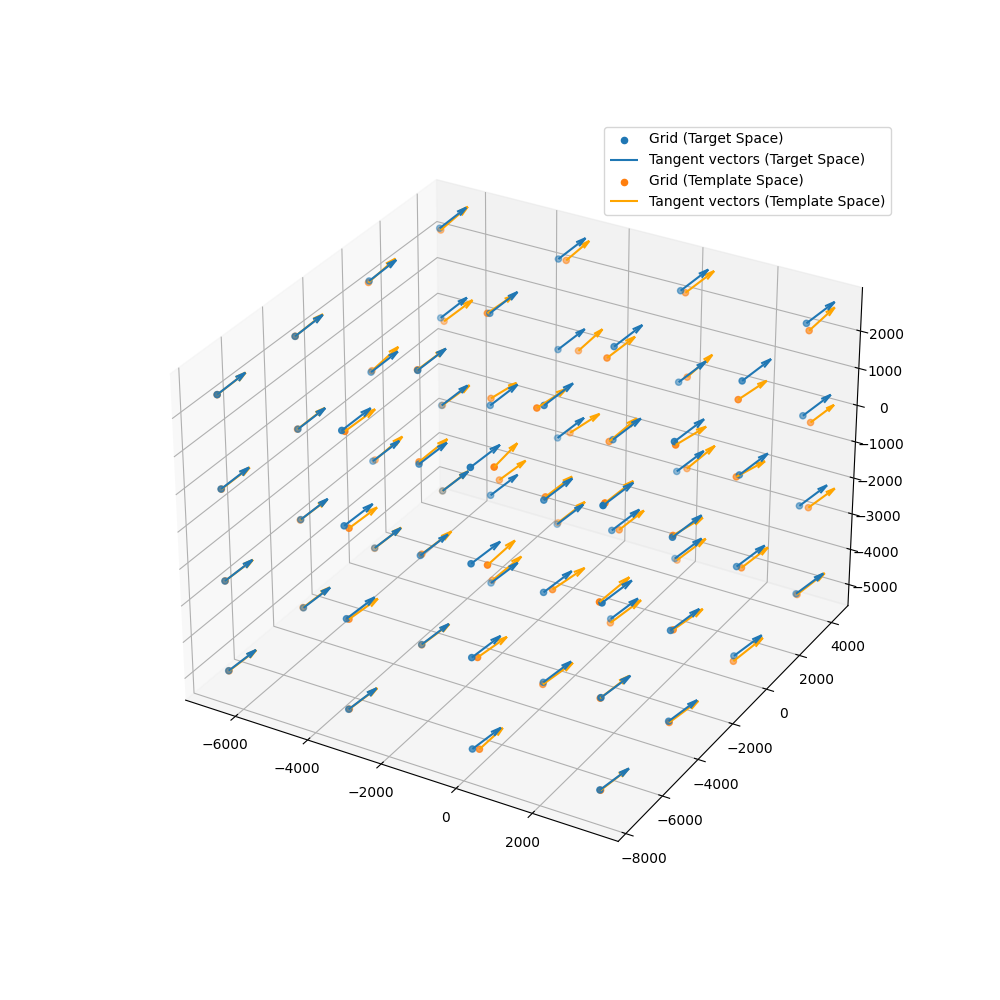

In [5]:
ct = CloudReg_Transform("/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/example_cloudreg/8604_Ch_561_registration/downloop_1_v.mat")

og_coords = ct.og_coords

xmin = np.amin(og_coords[0])
xmax = np.amax(og_coords[0])
ymin = np.amin(og_coords[1])
ymax = np.amax(og_coords[1])
zmin = np.amin(og_coords[2])
zmax = np.amax(og_coords[2])

xs = np.arange(xmin, xmax, (xmax-xmin)/4)
ys = np.arange(ymin, ymax, (ymax-ymin)/4)
zs = np.arange(zmin, zmax, (zmax-zmin)/4)

og_coords = np.meshgrid(xs,ys,zs, indexing='ij')
og_coords = np.array([og_coords[0].flatten(),og_coords[1].flatten(),og_coords[2].flatten()]).T


fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(og_coords[:,0],og_coords[:,1],og_coords[:,2], label="Grid (Target Space)")

ax = fig.gca(projection='3d')
ax.quiver(og_coords[:,0],og_coords[:,1],og_coords[:,2], np.ones((og_coords.shape[0])), np.ones((og_coords.shape[0])), np.ones((og_coords.shape[0])), length=500, label="Tangent vectors (Target Space)")

new_coords = ct.evaluate(og_coords)
print(f"average squared deformation {np.sum((og_coords-new_coords)**2)/og_coords.shape[0]}")
new_derivs = ct.D(og_coords, np.ones(og_coords.shape))
sns = []
for new_deriv in new_derivs:
    sn = cosine(new_deriv, [1,1,1])
    sns.append(sn)
print(f"average 1-cosine between derivatives {np.mean(sns)}")

ax.scatter3D(new_coords[:,0],new_coords[:,1],new_coords[:,2], label="Grid (Template Space)")
ax.quiver(new_coords[:,0],new_coords[:,1],new_coords[:,2], new_derivs[:,0],new_derivs[:,1],new_derivs[:,2], length=500, color='orange', label="Tangent vectors (Template Space)")
ax.legend()

Template space: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


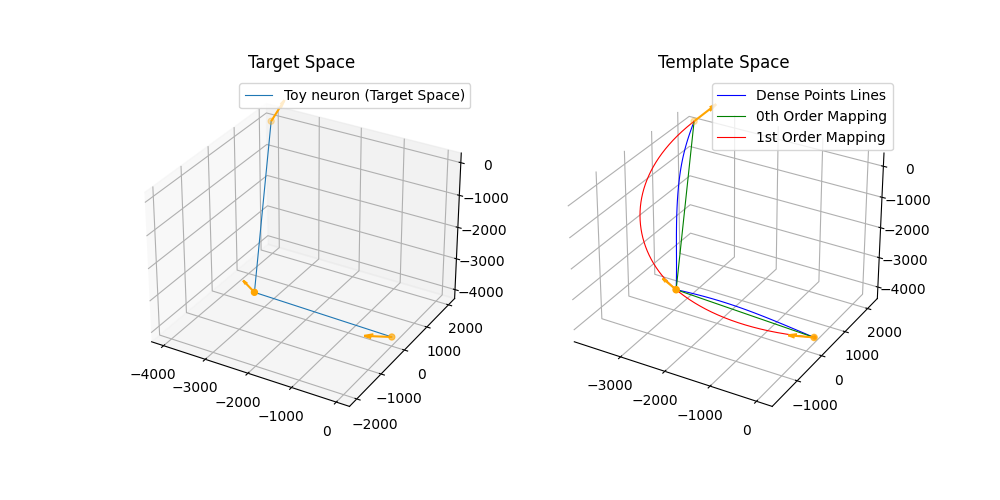

In [6]:
dict = {"x": [0, -2000, -4000], "y": [0, -2000, 2000], "z": [-4000, -2000, 0], "sample": [1,2, 3], "parent": [-1, 1, 2]}
df = pd.DataFrame(data = dict)

G = GeometricGraph(df = df)
spline_tree = G.fit_spline_tree_invariant()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1, projection="3d")

ax.scatter(df['x'].to_numpy(), df['y'].to_numpy(), df['z'].to_numpy(), linestyle='-',linewidth=0.8, color='orange')
G_tranformed = transform_GeometricGraph(G, ct)
soma = np.array(G_tranformed.nodes[G_tranformed.root]["loc"])
spline_tree = G.spline_tree
for node in tqdm(spline_tree.nodes, desc="Target space"):
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    # trace points only
    pts = splev(u, tck)
    ax.plot(pts[0], pts[1], pts[2], linestyle='-',linewidth=0.8, label="Toy neuron (Target Space)")
    derivs = splev(u, tck, der = 1)
    ax.quiver(pts[0], pts[1], pts[2], derivs[0], derivs[1], derivs[2],length=500, color='orange')

    # spline
    u2 = np.arange(u[0], u[-1]+0.01, 0.01)
    pts2 = splev(u2, tck)
    #ax.plot(pts2[0], pts2[1], pts2[2], linestyle='-',linewidth=0.8, label="Spline (Target Space)")
ax.set_title("Target Space")
ax.legend()

ax = fig.add_subplot(1, 2, 2, projection="3d")
for node in tqdm(spline_tree.nodes, desc="Template space"):
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)

    #dense line points
    tck_line, u_line = splprep(pts.T, k=1, s=0)
    u_line = np.arange(u_line[0], u_line[-1]+0.01, 0.01)
    pts_line = splev(u_line, tck_line)
    pts_line = np.stack(pts_line, axis=1)
    trans_pts = ct.evaluate(pts_line)
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, color='blue', label="Dense Points Lines")

    #dense spline points
    u_spline = np.arange(u[0], u[-1]+0.01, 0.01)
    pts_spline = splev(u_spline, tck)
    pts_spline = np.stack(pts_spline, axis=1)
    trans_pts = ct.evaluate(pts_spline)
    #ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, color="orange", label="Dense Points Spline")

    #Transformed points
    trans_pts = ct.evaluate(pts)
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, label="0th Order Mapping", color='green')
    ax.scatter(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], color="orange")
    derivs = splev(u, tck, der=1)
    derivs = np.stack(derivs, axis=1)
    trans_derivs = ct.D(pts, derivs)
    ax.quiver(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], trans_derivs[:,0], trans_derivs[:,1], trans_derivs[:,2],length=500, color="orange")


#act on derivatives
soma = np.array(G_tranformed.nodes[G_tranformed.root]["loc"])
spline_tree = G_tranformed.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1]+0.01, 0.01)
    chspline = spline[0]
    pts = chspline(u)

    ax.plot(pts[:,0], pts[:,1], pts[:,2], linestyle='-',linewidth=0.8, label="1st Order Mapping", color='red')
ax.set_title("Template Space")
ax.scatter(soma[0],soma[1],soma[2], c='darkorange', s=5)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)

ax.legend()
plt.show()

## CloudReg + Real Neuron

integrating velocity field: 100%|██████████| 10/10 [00:24<00:00,  2.43s/it]
/var/folders/fq/9t66hqz51y5ddnygddgjtsmc0000gn/T/ipykernel_84205/975484850.py:24: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


average squared deformation 80.57784710875386
average 1-cosine between derivatives 4.008348995467731e-06


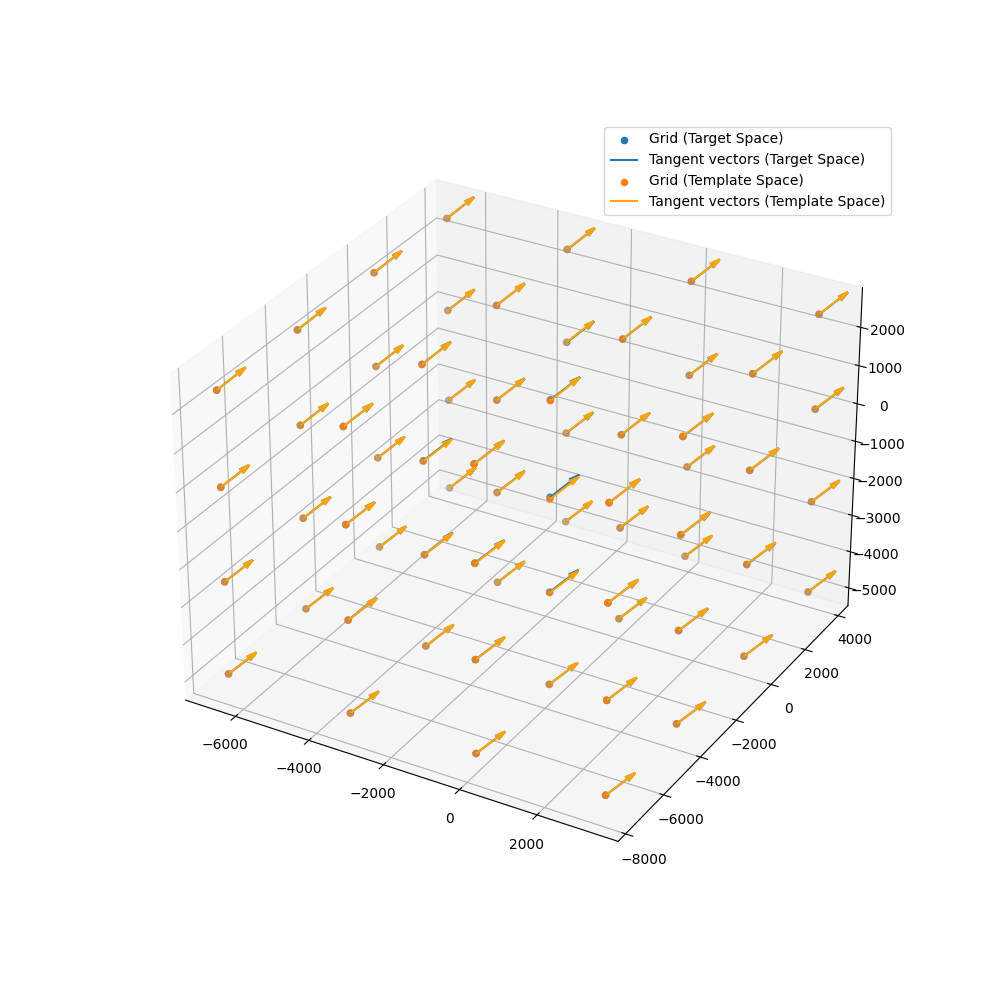

In [8]:
ct = CloudReg_Transform("/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/janelia_cloudreg/precomputed_ch1_otsu_iso_registration/downloop_1_v.mat")

og_coords = ct.og_coords

xmin = np.amin(og_coords[0])
xmax = np.amax(og_coords[0])
ymin = np.amin(og_coords[1])
ymax = np.amax(og_coords[1])
zmin = np.amin(og_coords[2])
zmax = np.amax(og_coords[2])

xs = np.arange(xmin, xmax, (xmax-xmin)/4)
ys = np.arange(ymin, ymax, (ymax-ymin)/4)
zs = np.arange(zmin, zmax, (zmax-zmin)/4)

og_coords = np.meshgrid(xs,ys,zs, indexing='ij')
og_coords = np.array([og_coords[0].flatten(),og_coords[1].flatten(),og_coords[2].flatten()]).T

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.scatter3D(og_coords[:,0],og_coords[:,1],og_coords[:,2], label="Grid (Target Space)")

ax = fig.gca(projection='3d')
ax.quiver(og_coords[:,0],og_coords[:,1],og_coords[:,2], np.ones((og_coords.shape[0])), np.ones((og_coords.shape[0])), np.ones((og_coords.shape[0])), length=500, label="Tangent vectors (Target Space)")

new_coords = ct.evaluate(og_coords)
print(f"average squared deformation {np.sum((og_coords-new_coords)**2)/og_coords.shape[0]}")
new_derivs = ct.D(og_coords, np.ones(og_coords.shape))
sns = []
for new_deriv in new_derivs:
    sn = cosine(new_deriv, [1,1,1])
    sns.append(sn)
print(f"average 1-cosine between derivatives {np.mean(sns)}")

ax.scatter3D(new_coords[:,0],new_coords[:,1],new_coords[:,2], label="Grid (Template Space)")
ax.quiver(new_coords[:,0],new_coords[:,1],new_coords[:,2], new_derivs[:,0],new_derivs[:,1],new_derivs[:,2], length=500, color='orange', label="Tangent vectors (Template Space)")
ax.legend()

1st order mappings: 100%|██████████| 226/226 [00:02<00:00, 105.70it/s]
/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')
/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


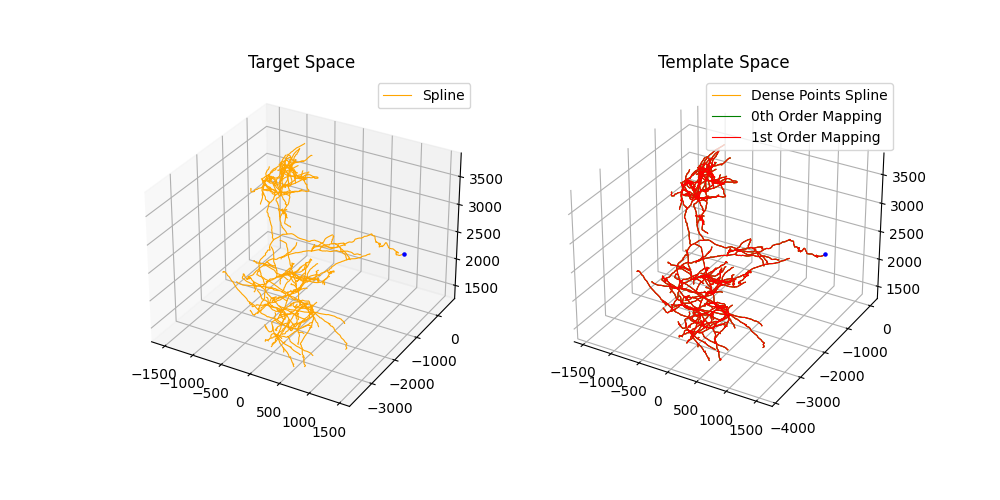

In [37]:
vol_im = CloudVolume("precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/janelia_cloudreg/ch1_otsu_iso")
origin = (np.array(vol_im.info['scales'][0]['size']) - 1) * np.array(vol_im.info['scales'][0]['resolution']) / 2

vol = CloudVolume("precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/janelia_cloudreg/axons_atlas")
skel = vol.skeleton.get(11)
coords = (skel.vertices - origin)/1000

G = GeometricGraph()
for id, coord in enumerate(coords):
    G.add_node(id, loc=coord)
for edge in skel.edges:
    G.add_edge(edge[0], edge[1])



spline_tree = G.fit_spline_tree_invariant()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1, projection="3d")

#ax.scatter(df['x'].to_numpy(), df['y'].to_numpy(), df['z'].to_numpy(), linestyle='-',linewidth=0.8)
G_tranformed = transform_GeometricGraph(G, ct)
soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.spline_tree

for i, node in enumerate(tqdm(spline_tree.nodes, desc="Target space")):
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    # trace points only
    pts = splev(u, tck)
    if i == 0:
        label = "Toy neuron (Target Space)"
    else:
        label = None
    #ax.plot(pts[0], pts[1], pts[2], linestyle='-',linewidth=0.8, label=label, color="blue")
    derivs = splev(u, tck, der = 1)
    #ax.quiver(pts[0], pts[1], pts[2], derivs[0], derivs[1], derivs[2],length=500, color='orange')

    # spline
    u2 = np.arange(u[0], u[-1]+0.01, 0.01)
    pts2 = splev(u2, tck)
    if i == 0:
        label = "Spline"
    else:
        label = None
    ax.plot(pts2[0], pts2[1], pts2[2], linestyle='-',linewidth=0.8, label=label, color="orange")


ax.scatter(soma[0],soma[1],soma[2], c='blue', s=5)
ax.set_title("Target Space")
ax.legend()
ax = fig.add_subplot(1, 2, 2, projection="3d")

for i, node in enumerate(tqdm(spline_tree.nodes, desc="0th order mappings")):
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)


    #dense line points
    tck_line, u_line = splprep(pts.T, k=1, s=0)
    u_line = np.arange(u_line[0], u_line[-1]+0.01, 0.01)
    pts_line = splev(u_line, tck_line)
    pts_line = np.stack(pts_line, axis=1)
    trans_pts = ct.evaluate(pts_line)
    if i == 0:
        label = "Dense Points Lines"
    else:
        label = None
    #ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, color='blue', label=label)

    #dense spline points
    u_spline = np.arange(u[0], u[-1]+0.01, 0.01)
    pts_spline = splev(u_spline, tck)
    pts_spline = np.stack(pts_spline, axis=1)
    trans_pts = ct.evaluate(pts_spline)
    if i == 0:
        label = "Dense Points Spline"
    else:
        label = None
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, color="orange", label=label)

    #Transformed points
    trans_pts = ct.evaluate(pts)
    if i == 0:
        label = "0th Order Mapping"
    else:
        label = None
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',linewidth=0.8, label=label, color='green')
    #ax.scatter(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], color="orange")
    derivs = splev(u, tck, der=1)
    derivs = np.stack(derivs, axis=1)
    trans_derivs = ct.D(pts, derivs)
    #ax.quiver(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], trans_derivs[:,0], trans_derivs[:,1], trans_derivs[:,2],length=500, color="orange")

#act on derivatives
soma = np.array(G_tranformed.nodes[G_tranformed.root]["loc"])
spline_tree = G_tranformed.spline_tree
for i, node in enumerate(tqdm(spline_tree.nodes, desc="1st order mappings")):
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1]+0.01, 0.01)
    chspline = spline[0]
    pts = chspline(u)

    if i == 0:
        label = "1st Order Mapping"
    else:
        label = None
    ax.plot(pts[:,0], pts[:,1], pts[:,2], linestyle='-',linewidth=0.8, label=label, color='red')

ax.scatter(soma[0],soma[1],soma[2], c='blue', s=5)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
ax.set_title("Template Space")
ax.legend()

plt.show()

## Linear Transformation

In [ ]:
class LinearTransformation(DiffeomorphismAction):
    def __init__(self, A, b):
        self.A = A
        self.b =  b

    def evaluate(self, position: np.array) -> np.array:
        transformed_position = np.matmul(self.A, position.T).T
        transformed_position = np.add(transformed_position, self.b)
        return transformed_position
    
    def D(self, position: np.array, deriv: np.array, order: int = 1) -> np.array:
        transformed_deriv = np.matmul(self.A, deriv.T).T
        return transformed_deriv


## Real Neuron

In [74]:
brainlit_path=Path.cwd().parent.parent.parent
swc=Path.joinpath(brainlit_path,'data','data_octree','consensus-swcs','2018-08-01_G-002_consensus.swc')
nt = NeuronTrace(path=str(swc))
df = nt.get_df()
neuron = GeometricGraph(df=df)


In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")
soma = np.array(neuron.nodes[neuron.root]["loc"])
spline_tree = neuron.fit_spline_tree_invariant()
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    u = np.arange(u[0], u[-1]+0.1, 0.1)
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    trans_pts = diff.evaluate(pts)
    ax.plot(trans_pts[:,0], trans_pts[:,1], trans_pts[:,2], linestyle='-',color='midnightblue',linewidth=0.8, label="Mapping Dense Points")

ax.scatter(soma[0],soma[1],soma[2], c='darkorange', s=5)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)


plt.show()

In [ ]:
diff = LinearTransformation(A = np.array([[2,0,0],[0,1,0],[0,0,1]]), b = [1000,0,0])
neuron_tranformed = transform_GeometricGraph(neuron, diff)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")
soma = np.array(neuron_tranformed.nodes[neuron.root]["loc"])
spline_tree = neuron_tranformed.spline_tree
for node in spline_tree.nodes:
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1]+0.1, 0.1)
    chspline = spline[0]
    pts = chspline(u)

    ax.plot(pts[:,0], pts[:,1], pts[:,2], linestyle='-',color='midnightblue',linewidth=0.8, label="Mapping Endpoints and Derivatives")
ax.scatter(soma[0],soma[1],soma[2], c='darkorange', s=5)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)


plt.show()